side note: why is logistic regression different from linear regression? logistic make use of sigmoid function to learn non-linear pattern

# **Logistic Regression**

In this tutorial, we will solve a *binary classification* problem with logistic regression using gradient descend.

## Dataset
We have a training set composed of 2-dimensional inputs:
$\mathbf{x}_i = [x_1, x_2]^T$, where $\mathbf{x}_i \in \mathbb{R}^2$.
For convenience, we gather all the inputs into a matrix $\mathbf{X}$:


$\mathbf{X} = \begin{bmatrix}
1 & x_{1,1} & x_{1,2}\\
1 & x_{2,1} & x_{2,2}\\
1 & ...  & ...\\
1 & x_{N,1} & x_{N,2}\\
\end{bmatrix}$

where $\mathbf{X} \in \mathbb{R}^{N \times 3}$.

For each input, we have a label that can be 0 or 1:

$y_i = \{0,1\}$

Again, it is convenient to gather all the labels into a vector:

$\mathbf{y} =[y_{1},y_{2},..,y_{i}, ..., y_{N}]^T$, where $\mathbf{y} \in \mathbb{R}^N$.


## Model
The logistic regression maps the input $\mathbf{x}_i$ into the following output:

$p(y_i = 1 \mid \mathbf{x}_i, \mathbf{w}) = \sigma(\mathbf{w}^T\mathbf{x}_i) =  \sigma(w_0 + w_1 x_1 + w_2 x_2)$.

The vectorized version is the following:

$p(\mathbf{y} = 1 \mid \mathbf{X}, \mathbf{w}) = \sigma(\mathbf{X}\mathbf{w})$,

where the output is a N-dimensional vector. With the vectorized version, we can compute the output of the model in one-shot, without looping over all the inputs. $\sigma$ is the sigmoid function, that is defined as:

$\sigma(z) = \frac{1}{1 + e^{-z}} = (1+e^{-z})^{-1}$

The vector $\mathbf{w}=[w_0,w_1,w_2]^T$, instead, collects all the three learnable parameters.


## Objective
Our goal is to find a configuration of our parameters $\mathbf{w}$ that minimizes our objective function (BCE).
For logistic regression, we use the binary cross-entropy loss:

$J(\mathbf{w}) = -\sum_{i=1}^N y_i \ln P(y_i = 1 \mid \mathbf{x}_i, \mathbf{w}) + (1-y_i) \ln(1- P(y_i = 1 \mid \mathbf{x}_i, \mathbf{w}))$.

The BCE is low when the output probabilities are close to their corresponding labels.

# Data Generation

Let's use the following function to generate our binary data. As usual, remember that the data generation process is something not accessible directly in a real machine learning problem (e.g., think about the hidden process that generates complex data like images or speech signals).

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

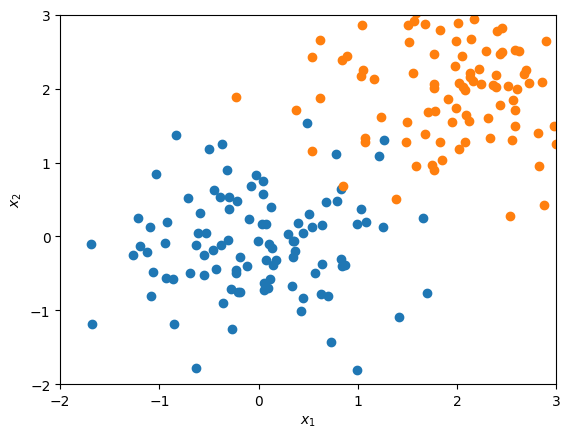

In [ ]:
def get_dataset(N=100,
                mu0 = np.array([0,0]),
                cov0 = np.array([[0.5,0],[0,0.5]]),
                mu1 = np.array([2,2]),
                cov1 = np.array([[0.5,0],[0,0.5]])):
  """Creates data for binary classification by drawing samples from gaussians"""

  # Class 0 samples
  x0 = np.random.multivariate_normal(mu0, cov0, N)
  y0 = np.zeros(x0.shape[0])

  # Class 1 samples
  x1 = np.random.multivariate_normal(mu1, cov1, N)
  y1 = np.ones(x1.shape[0])

  X = np.concatenate([x0,x1])
  # Adding the ones is needed to vectorize everything (see lecture)
  X = np.concatenate([np.ones([X.shape[0],1]), X], axis=1)
  y = np.concatenate([y0,y1])
  return X,y

def plot_data(X_train, y_train, xmin=-2, xmax = 3, ymin =-2, ymax = 3):
  """Scatterplot of the data with their labels"""
  plt.scatter(X_train[y_train==0][:,1], X_train[y_train==0][:,2])
  plt.scatter(X_train[y_train==1][:,1], X_train[y_train==1][:,2])
  plt.xlim(xmin, xmax)
  plt.ylim(ymin, ymax)
  plt.ylabel(r'$x_2$')
  plt.xlabel(r'$x_1$')
  plt.show()


# Sample data for test and training
X_train, y_train = get_dataset()
X_test, y_test = get_dataset()

# Plot training data
plot_data(X_train,y_train)

Let's define some support functions that we will use during training:

In [ ]:
def sigmoid(z):
  return 1/(1 + np.exp(-z))

def logistic_regression(X, w):
  "Logistic regression. We here use the vectorized form to\
  improve parallelization and make everything more efficient."
  return sigmoid(np.dot(X,w))

def binary_cross_entropy(y_hat,y):
    "Computes the binary-corss entropy given the predictions and\
    the labels."
    bce = y * np.log(y_hat) + (1-y) * (np.log(1-y_hat))
    return -bce.mean()

def plot_boundaries(w, xmin=-2, xmax = 3, ymin =-2, ymax = 3):
  "This function plots the boudaries given the current weights."
  xd = np.array([xmin, xmax])
  yd = -(w[0])/w[2] -(w[1]/w[2])*xd
  plt.plot(xd, yd, 'k', lw=1, ls='--')
  plt.fill_between(xd, yd, ymin, color='tab:blue', alpha=0.2)
  plt.fill_between(xd, yd, ymax, color='tab:orange', alpha=0.2)



# **Logistic Regression with NumPy**
All right, we can now implement gradient descend. To use it, we need to compute the gradient of the objective function over the learnable parameters. As we have seen in the lectures, this gradient is given by:

$
\nabla LL (\mathbf{w}) = \sum_{i=0}^N  \big( \sigma (\mathbf{w}^T \mathbf{x}_i) - y_i \big) \mathbf{x}_i = \mathbf{X}^T(\sigma(\mathbf{X} \mathbf{w})-\mathbf{y})$

We are going to use here the fully vectorized form (i.e., the last one in the previous equation). Remember that in machine learning we have to avoid as much as possible *for loops* when implementing our model. For loops can be slow, while matrix multiplications can be easily parallelized.

To make this vectorized form possible, the input matrix $X$ should look like this:

$\mathbf{X} = \begin{bmatrix}
1 & x_{1,1} & x_{1,2} \\
1 & x_{2,1} & x_{2,2}\\
1 & ... & ... \\
1 & x_{N,1} & x_{N,2}\\
\end{bmatrix}$

We have to append a column of ones (needed to manage the bias term).

The following function is going to implement a basic version of gradient descend:
- We initialize the parameters $\mathbf{w}$ with random numbers
- We initialize the hyperparameters (learning rate and number of epochs)
- We compute the gradient, update the parameters, and loop for the specified number of epochs.

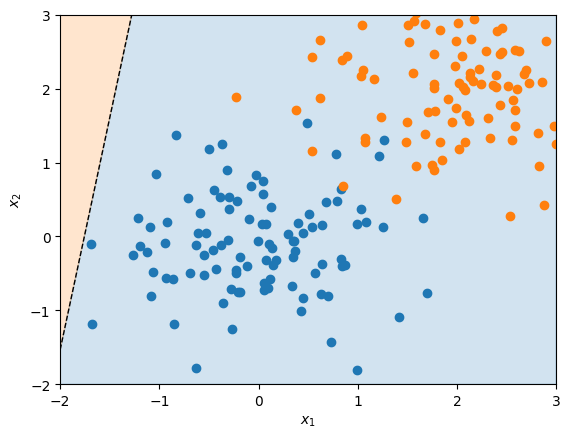

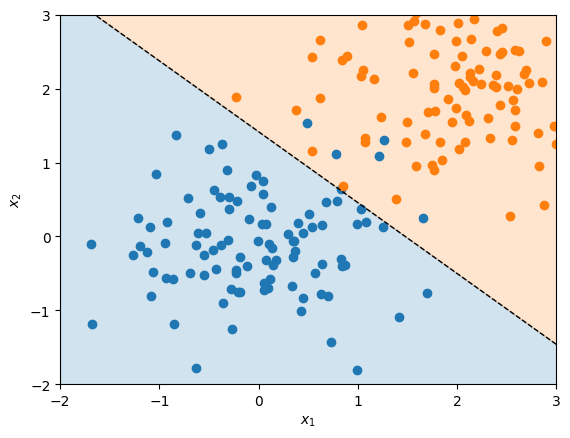

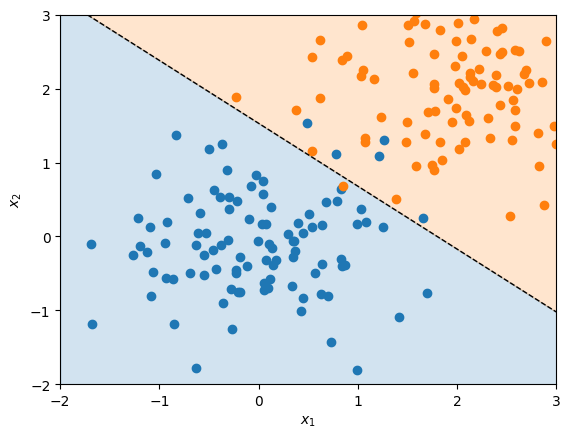

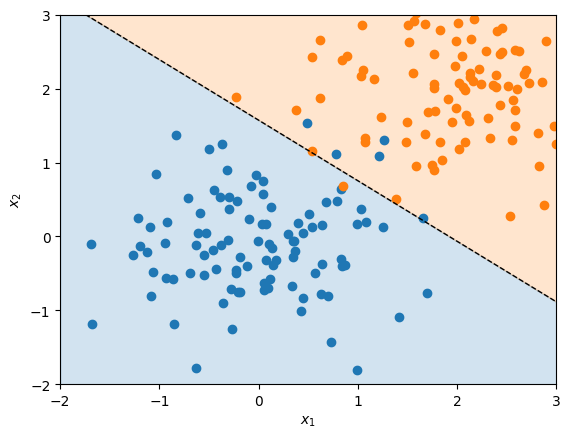

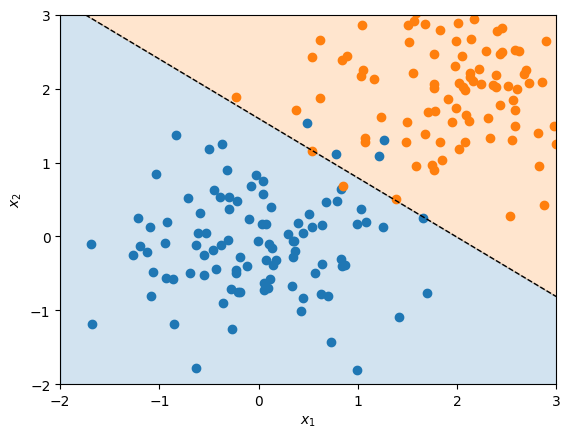

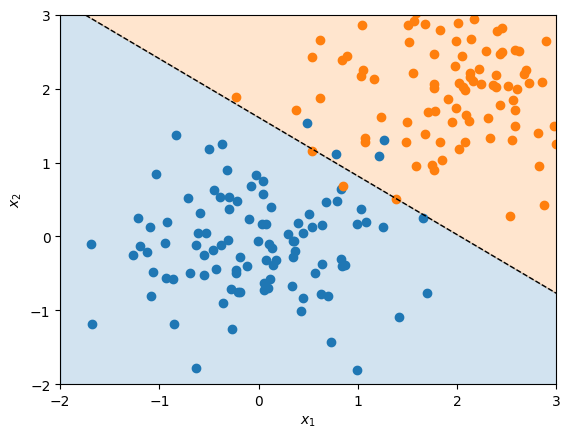

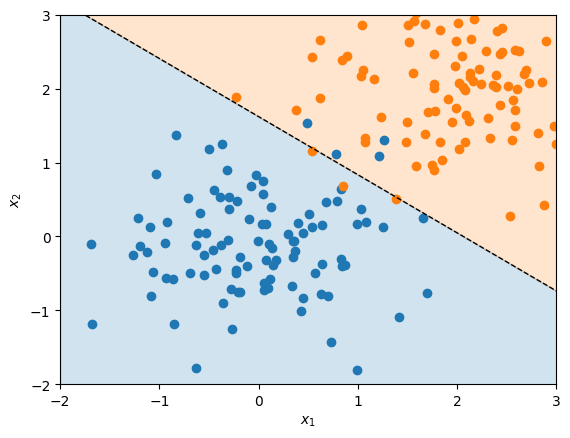

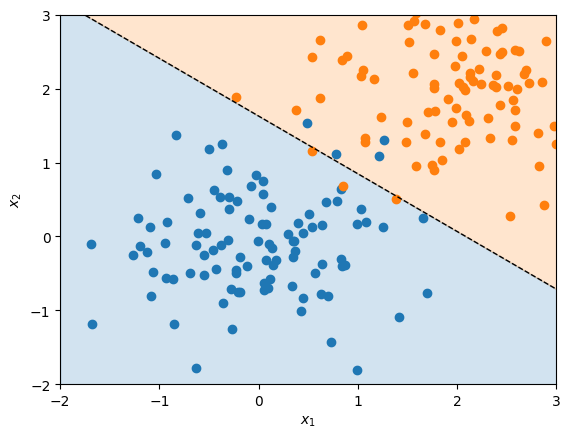

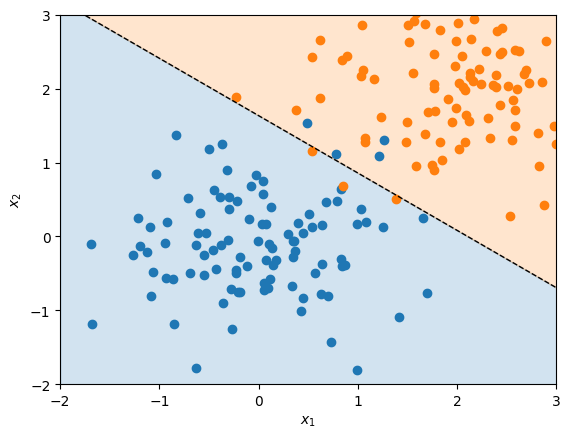

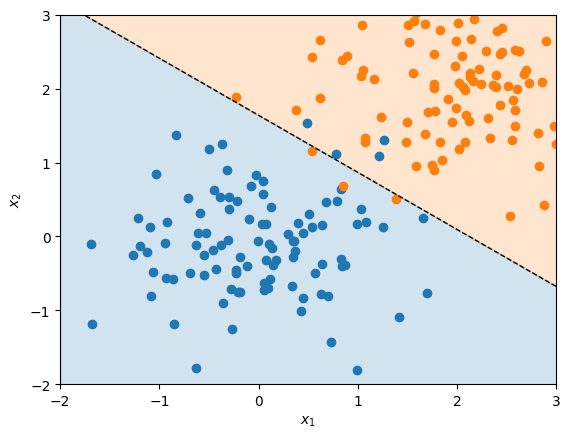

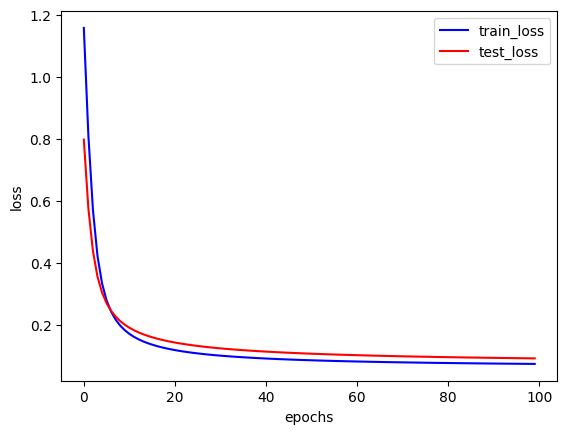

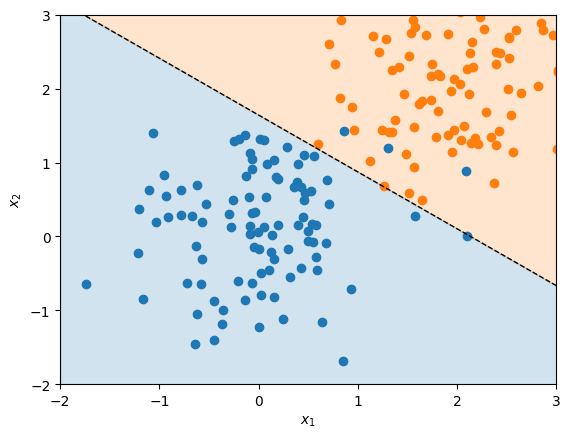

[-4.51676838  2.11377205  2.74925106]


In [ ]:
# Initial Values
w = np.array([2.0, 0.5, -0.5])
N_epochs = 100
lr = 0.01
plot_every=10

train_losses = []
test_losses = []
for epoch in range(N_epochs):

  # compute the predictions
  y_hat = logistic_regression(X_train, w)

  # compute the gradient
  grad = np.dot(X_train.T,(y_hat - y_train))

  # parameter updates with gradient descend
  w = w -lr * grad

  # Loss computation (just to monitor)
  tr_loss = binary_cross_entropy(y_hat,y_train)
  y_hat_test = logistic_regression(X_test, w)
  te_loss = binary_cross_entropy(y_hat_test,y_test)

  # Store the training and test losses (just to monitor)
  train_losses.append(tr_loss)
  test_losses.append(te_loss)

  # Plot the data and the classification with the decision boundary.
  if epoch % plot_every == 0:
    plot_boundaries(w)
    plot_data(X_train,y_train)


# Plot the training curve
plt.plot(train_losses, color='blue')
plt.plot(test_losses, color='red')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_loss','test_loss'])
plt.show()

# Plot the test data
plot_boundaries(w)
plot_data(X_test,y_test)

print(w)

The algorithm starts from a bad solution. Thanks to gradient descend, however, we quickly improve it. At the end, the solution classifies pretty the test data as well.



# **Logistic Regression with scikit learn**

The scikit learn library has a build-in function for linear regression. We can use it in this way:

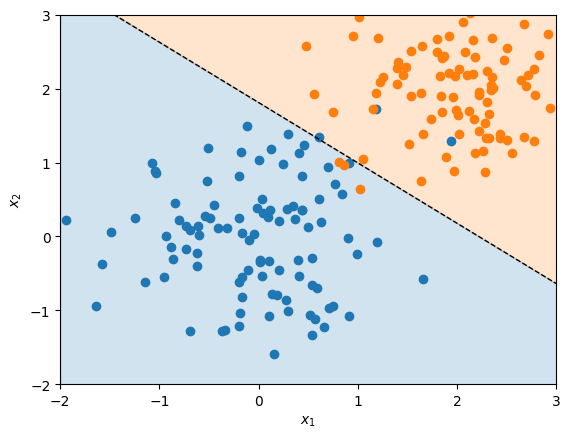

[-4.88248832  2.19913573  2.69406736]


In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train[:,1:], y_train)
w = np.array([clf.intercept_[0], clf.coef_[0][0], clf.coef_[0][1]])

# Plot the test data
plot_boundaries(w)
plot_data(X_test,y_test)

print(w)

As you can see the solution found with our implementation is very similar to that obtained by scikit learn. Note, however, that by default scikit learn applies L2 regularization.

# **Logistic Regression with Feature Transformation**

The previous version of logistic regression can be used only if the two classes are **linearly separable**. Unfortunately, this is not the case in many machine learning problems. However, we can try to transform our features with a transformation $\phi(\mathbf{x})$ and hope to improve their separability.  

We are going to now see an example of a logistic regression coupled with a feature transformation. We have to generate a dataset a little bit more challenging than the one used before. In this case, we draw samples from two concatenated ellipses. We also add noise to model uncertainty in the observations.

In [ ]:
def elipse_samples(N, u=1, v=0.5, a=2., b=1.5, sigma_noise = 0.3):
  """Draws data from an elipse function (by addding a small noise)

  Arguments:
   N (int): Number of data points to sample
   u (float): x-position of the center
   v (float): y-position of the center
   a (float): radius on the x-axis
   b (float): radius on the y-axis
   sigma_noise: standard deviation applied to the additive noise

  Returns
  x (np.array): samples drawn from the ellipse
  """
  t = np.random.uniform(low=0.0, high=2*math.pi, size=N)
  x1 = u+a*np.cos(t) + np.random.normal(loc=0.0, scale=sigma_noise, size=N)
  x2 =  v+b*np.sin(t) +  np.random.normal(loc=0.0, scale=sigma_noise , size=N)
  return np.stack([x1,x2]).T


def get_dataset(N=100,
                mu0 = np.array([0,0]),
                cov0 = np.array([[0.5,0],[0,0.5]]),
                mu1 = np.array([2,2]),
                cov1 = np.array([[0.5,0],[0,0.5]])):
  """Creates data for binary classification by drawing samples from the ellipse"""

  # Class 0 samples
  x0 = elipse_samples(N, u=0, v=0, a=2., b=1.5)
  y0 = np.zeros(x0.shape[0])

  # Class 1 samples
  x1 = elipse_samples(N, u=0, v=0, a=0.5, b=0.1)
  y1 = np.ones(x1.shape[0])

  X = np.concatenate([x0,x1])
  # Adding the ones is needed to vectorize everything (see lecture)
  X = np.concatenate([np.ones([X.shape[0],1]), X], axis=1)
  y = np.concatenate([y0,y1])
  return X,y

def plot_data(X_train, y_train, xmin=-2.5, xmax = 2.5,
              ymin =-2.5, ymax = 2.5,
              xlab='$x_1$', ylab='$x_2$'):
  """Scatterplot of the data with their labels"""
  plt.scatter(X_train[y_train==0][:,1], X_train[y_train==0][:,2])
  plt.scatter(X_train[y_train==1][:,1], X_train[y_train==1][:,2])
  plt.xlim(xmin, xmax)
  plt.ylim(ymin, ymax)
  plt.ylabel(ylab)
  plt.xlabel(xlab)
  plt.show()


def plot_boundaries(w, xmin=-2.5, xmax = 3, ymin =-2.5, ymax = 3):
  "This function plots the boudaries given the current weights."
  xd = np.array([xmin, xmax])
  yd = -(w[0])/w[2] -(w[1]/w[2])*xd
  plt.plot(xd, yd, 'k', lw=1, ls='--')
  plt.fill_between(xd, yd, ymin, color='tab:blue', alpha=0.2)
  plt.fill_between(xd, yd, ymax, color='tab:orange', alpha=0.2)

We can now draw our dataset and plot it:

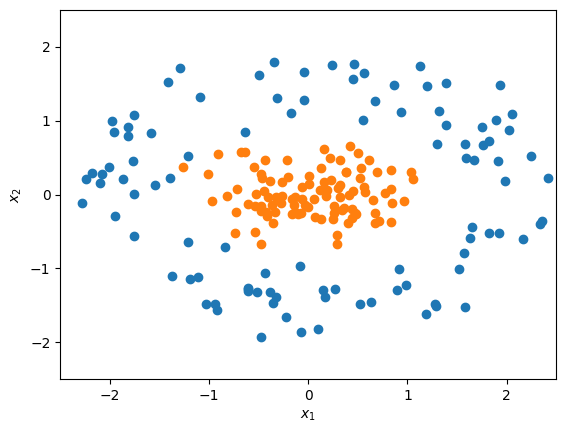

In [ ]:
# Sample data for test and training
X_train, y_train = get_dataset()
X_test, y_test = get_dataset()

# Plot training data
plot_data(X_train,y_train)

As you can see, the two classes are not linearly separable in this case. If we apply logistic regression on top of this data directly, it does not find a meaningful solution:


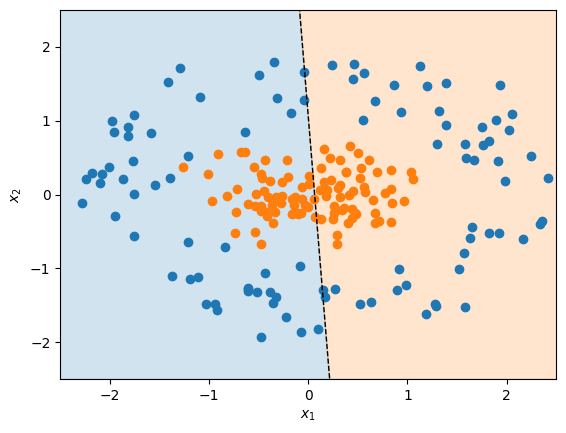

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train[:,1:], y_train)
w = np.array([clf.intercept_[0], clf.coef_[0][0], clf.coef_[0][1]])

plot_boundaries(w)
plot_data(X_train,y_train)

How can we make our classes linearly separable? We can try to think about a meaningful transformation to apply to our data. In this case, a good idea could be to transform the features in this way:

$\phi_1(\mathbf{x}) = \sqrt{x_1^2+x_2^2}$

$\phi_2(\mathbf{x}) = atan(\frac{x_2}{x_1})$

We basically switch from cartesian the polar cordinates.
Let's apply this transformation and plot the data:

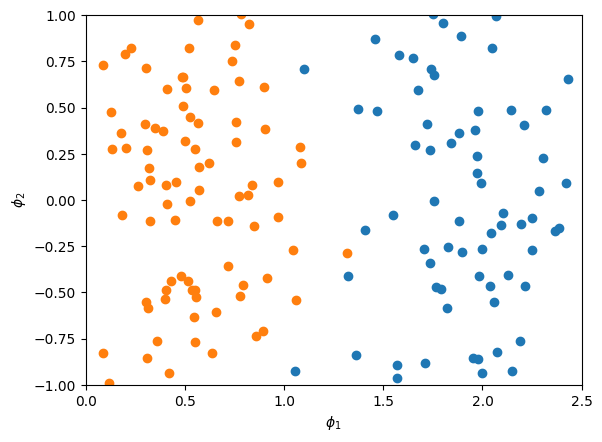

In [ ]:
# Data transformation
X_train_tr = np.zeros_like(X_train)
X_train_tr[:,1] = np.sqrt(X_train[:,1] ** 2 + X_train[:,2] ** 2)
X_train_tr[:,2] = np.arctan(X_train[:,2]/X_train[:,1])

plot_data(X_train_tr,y_train, xmin=0, xmax = 2.5, ymin =-1, ymax = 1,  xlab='$\phi_1$', ylab='$\phi_2$')

Now the classes look much more linearly separable. Let's apply logistic regression on top of the transformed features:

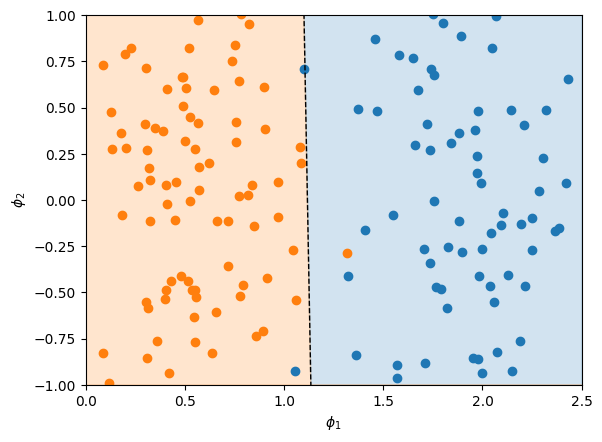

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train_tr[:,1:], y_train)
w = np.array([clf.intercept_[0], clf.coef_[0][0], clf.coef_[0][1]])

# Plot the test data
plot_boundaries(w,  xmin=0, xmax = 2.5, ymin =1, ymax = -1)
plot_data(X_train_tr,y_train,  xmin=0, xmax = 2.5, ymin =-1, ymax = 1, xlab='$\phi_1$', ylab='$\phi_2$')

We finally found a good solution to our problem. Note that the boundaries are linear in the transformed space, but are **non-linear** in the **input space $\mathbf{x}$**.

One problem with this approach is that finding by hand a proper transformation that makes our dataset linearly separable is not an easy task. In the next lectures, we will see how this problem is addressed in the context of neural networks and support vector machines.